In [40]:
# Import libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
from termcolor import colored
import pandas as pd
import numpy as np
import requests
import PyPDF2
import re
import plotly.graph_objects as go
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Kirudang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
# Load data
df = pd.read_csv('./dataset/nyc-jobs-1.csv')
# Check data
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,,,...,"Salary range for this position is: $42,405 - $...",,,,NaN,New York City residency is generally required ...,2011-06-24T00:00:00,NaN,2011-06-24T00:00:00,2018-07-17T00:00:00
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,,F,...,,"In addition to applying through this website, ...",,,NaN,New York City residency is generally required ...,2012-01-26T00:00:00,NaN,2012-01-26T00:00:00,2018-07-17T00:00:00
2,102221,DEPT OF ENVIRONMENT PROTECTION,External,1,Project Specialist,ENVIRONMENTAL ENGINEERING INTE,20616,0,,F,...,Appointments are subject to OMB approval,click the apply now button,35 hours per week/day,,NaN,New York City Residency is not required for th...,2012-06-21T00:00:00,NaN,2012-09-07T00:00:00,2018-07-17T00:00:00
3,102221,DEPT OF ENVIRONMENT PROTECTION,Internal,1,Project Specialist,ENVIRONMENTAL ENGINEERING INTE,20616,0,,F,...,Appointments are subject to OMB approval,click the apply now button,35 hours per week/day,,NaN,New York City Residency is not required for th...,2012-06-21T00:00:00,NaN,2012-09-07T00:00:00,2018-07-17T00:00:00
4,114352,DEPT OF ENVIRONMENT PROTECTION,Internal,5,Deputy Plant Chief,SENIOR STATIONARY ENGINEER (EL,91639,0,,F,...,Appointments are subject to OMB approval Fo...,"Click ""Apply Now"" button",40 per week / day,Various,NaN,New York City residency is generally required ...,2012-12-12T00:00:00,NaN,2012-12-13T00:00:00,2018-07-17T00:00:00


Since head() fuction does not show all data, we check column names to retain only necessary variables.

In [43]:
# Show column name
df.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Code No', 'Level', 'Job Category',
       'Full-Time/Part-Time indicator', 'Salary Range From', 'Salary Range To',
       'Salary Frequency', 'Work Location', 'Division/Work Unit',
       'Job Description', 'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'],
      dtype='object')

Keep only some columns to train the model

In [44]:
df =df[['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills']]
df.head()

,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills
0,Account Manager,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â€¢\tExcellent interpersonal and organizationa...
1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,
2,Project Specialist,"Under direct supervision, perform elementary e...",A Baccalaureate degree from an accredited coll...,
3,Project Specialist,"Under direct supervision, perform elementary e...",A Baccalaureate degree from an accredited coll...,
4,Deputy Plant Chief,"Under general direction, is in responsible cha...",1. Six years of full-time satisfactory experie...,


In [45]:
# Create a new column called 'data' and merge the values of the other columns into it
df['data'] = df[['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
# Drop the individual columns if you no longer need them
df.drop(['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills'], axis=1, inplace=True)
# Preview the updated dataframe
print(df.head())

                                                data
0  Account Manager Division of Economic & Financi...
1  EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT The N...
2  Project Specialist Under direct supervision, p...
3  Project Specialist Under direct supervision, p...
4  Deputy Plant Chief Under general direction, is...


In [46]:
# Tag data
data = list(df['data'])
tagged_data = [TaggedDocument(words = word_tokenize(_d.lower()), tags = [str(i)]) for i, _d in enumerate(data)]

In [51]:
# Model initialization
model = Doc2Vec(vector_size = 50,
min_count = 5,
epochs = 100,
alpha = 0.001
)

In [52]:
# Vocabulary building
model.build_vocab(tagged_data)
# Get the vocabulary keys
keys = model.wv.key_to_index.keys()
# Print the length of the vocabulary keys
print(len(keys))

8599


#### 5. Train and save the model
Train the model on tagged data.

In [53]:
# Train the model
for epoch in range(model.epochs):
    print(f"Training epoch {epoch+1}/{model.epochs}")
    model.train(tagged_data, 
                total_examples=model.corpus_count, 
                epochs=model.epochs)

model.save('cv_job_maching.model')
print("Model saved")

Training epoch 1/100
Training epoch 2/100
Training epoch 3/100
Training epoch 4/100
Training epoch 5/100
Training epoch 6/100
Training epoch 7/100
Training epoch 8/100
Training epoch 9/100
Training epoch 10/100
Training epoch 11/100
Training epoch 12/100
Training epoch 13/100
Training epoch 14/100
Training epoch 15/100
Training epoch 16/100
Training epoch 17/100
Training epoch 18/100
Training epoch 19/100
Training epoch 20/100
Training epoch 21/100
Training epoch 22/100
Training epoch 23/100
Training epoch 24/100
Training epoch 25/100
Training epoch 26/100
Training epoch 27/100
Training epoch 28/100
Training epoch 29/100
Training epoch 30/100
Training epoch 31/100
Training epoch 32/100
Training epoch 33/100
Training epoch 34/100
Training epoch 35/100
Training epoch 36/100
Training epoch 37/100
Training epoch 38/100
Training epoch 39/100
Training epoch 40/100
Training epoch 41/100
Training epoch 42/100
Training epoch 43/100
Training epoch 44/100
Training epoch 45/100
Training epoch 46/1

In [55]:
pdf = PyPDF2.PdfReader('./CV/example.pdf')
resume = ""
for i in range(len(pdf.pages)):
    pageObj = pdf.pages[i]
    resume += pageObj.extract_text()

In [56]:
# JD by input text:
jd = input("Paste your JD here: ")

Paste your JD here:  Proactively engage with clients in the branch and deliver an outstanding service experience through completing transactions and by identifying opportunities for advice, solutions, digital enablement and partner introductions Focus on education and demonstration, leverage technology to deliver a memorable client experience, drive solutions and retain business Contribute to team results by listening and spotting opportunities to offer additional advice, introduce clients to the capability of RBC partners, or personally fulfil client solutions Proactively take ownership of resolving and preventing client banking problems Cultivate and maintain relationships with partners to work as one RBC team Manage risks by adhering to compliance routines, processes, and controls to protect client and shareholder interests while completing transactions What do you need to succeed?  Must-have  Goal-oriented individual with a demonstrated passion for putting clients first. Drive and 

In [37]:
jd = """
Proactively engage with clients in the branch and deliver an outstanding service experience through completing transactions and by identifying opportunities for advice, solutions, digital enablement and partner introductions
Focus on education and demonstration, leverage technology to deliver a memorable client experience, drive solutions and retain business
Contribute to team results by listening and spotting opportunities to offer additional advice, introduce clients to the capability of RBC partners, or personally fulfil client solutions
Proactively take ownership of resolving and preventing client banking problems
Cultivate and maintain relationships with partners to work as one RBC team
Manage risks by adhering to compliance routines, processes, and controls to protect client and shareholder interests while completing transactions
What do you need to succeed?

Must-have

Goal-oriented individual with a demonstrated passion for putting clients first.
Drive and self-motivation, as well as excellent communication skills and emotional intelligence
Digital literacy across a broad range of devices (i.e., smartphones, tablets, laptops, etc.)
Personal flexibility to work flex hours
Eagerness to learn and determination to succeed
Confidence and ability to learn financial concepts and willingness to obtain the Investment Funds in Canada or the Canadian Securities Course
Nice-to-have

Track record in building rapport and maintaining client relationships within the financial, service or retail industry
Mutual Funds accreditation
Is this job right for you? Check out our video and decide for yourself!

What’s in it for you?

We thrive on the challenge to be our best, progressive thinking to keep growing, and working together to deliver trusted advice to help our clients thrive and communities prosper. We care about each other, reaching our potential, making a difference to our communities, and achieving success that is mutual.

A comprehensive Total Rewards Program including bonuses and flexible benefits, competitive compensation, commissions, and stock where applicable
A world-class training program in financial services
Excellent career development and access to a variety of job opportunities across business and geographies
Leaders who support your development through coaching and managing opportunities
Work in a dynamic, collaborative, progressive, and high-performing team
We also strive to provide an accessible candidate experience for our prospective employees with different abilities. Please let us know if you need any accommodations during the recruitment process.

Join our Talent Community

Stay in-the-know about great career opportunities at RBC. Sign up and get customized info on our latest jobs, career tips and Recruitment events that matter to you.

Expand your limits and create a new future together at RBC. Find out how we use our passion and drive to enhance the well-being of our clients and communities at rbc.com/careers.
"""

In [57]:
def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove punctuation from the text
    text = re.sub('[^a-z]', ' ', text)
    
    # Remove numerical values from the text
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

In [58]:
# Apply to CV and JD
input_CV = preprocess_text(resume)
input_JD = preprocess_text(jd)

In [59]:
# Model evaluation
model = Doc2Vec.load('cv_job_maching.model')
v1 = model.infer_vector(input_CV.split())
v2 = model.infer_vector(input_JD.split())
similarity = 100*(np.dot(np.array(v1), np.array(v2))) / (norm(np.array(v1)) * norm(np.array(v2)))
print(round(similarity, 2))

52.28


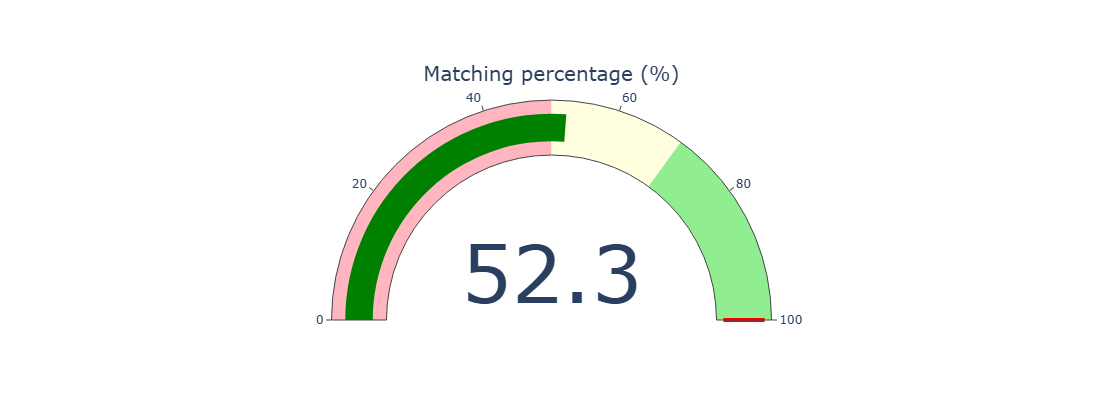

Good chance but you can improve further!


In [76]:
# Visualization
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = similarity,
    mode = "gauge+number",
    title = {'text': "Matching percentage (%)"},
    #delta = {'reference': 100},
    gauge = {
        'axis': {'range': [0, 100]},
        'steps' : [
            {'range': [0, 50], 'color': "#FFB6C1"},
            {'range': [50, 70], 'color': "#FFFFE0"},
            {'range': [70, 100], 'color': "#90EE90"}
        ],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}}))

fig.update_layout(width=600, height=400)  # Adjust the width and height as desired
fig.show()

# Print notification
if similarity < 50:
    print(colored("Low chance, need to modify your CV!", "red", attrs=["bold"]))
elif similarity >= 50 and similarity < 70:
    print(colored("Good chance but you can improve further!", "yellow", attrs=["bold"]))
else:
    print(colored("Excellent! You can submit your CV.", "green", attrs=["bold"]))